In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue

from environment import BaseEnvironment
from atari_breakout import AtariBreakoutEnvironment
from agent import BaseAgent 

from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import time
import shutil
from plot_script import plot_result
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

## Neural Network for action values

We use a neural network with one hidden layer for approximating the action-value function in a control problem. The output layer size is the number of actions. 

The get_action_values() function computes the action-value function by doing a forward pass.
The get_TD_update() function computes the gradient of the action-value function with respect to the weights times the TD error.

In [2]:
NAME_Save = "Breakout-CNN-C-32-8-4__Mpad__C-64-4-3__Mpad__C-64-3-1__Mpad__D-512-{}".format(int(time.time()))
NAME_Load = ""
class ActionValueNetwork:

    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_actions = network_config.get("num_actions")
        self.learning_rate = network_config.get("learning_rate")
        
#         inputs = layers.Input(shape=(self.state_dim, self.state_dim, 3))
#         # Convolutions on the frames on the screen
#         layer1 = layers.Conv2D(6, 7, strides=4, activation="relu")(inputs)
#         layer2 = layers.MaxPooling2D(pool_size = (2,2))(layer1)
#         layer3 = layers.Conv2D(12, 4, strides=2, activation="relu")(layer2)
#         layer4 = layers.MaxPooling2D(pool_size = (2,2))(layer3)
#         layer5 = layers.Flatten()(layer4)
#         layer6 = layers.Dense(512, activation="relu")(layer5)
#         action = layers.Dense(self.num_actions, activation="linear")(layer6)

#         self.model =  keras.Model(inputs=inputs, outputs=action)
        
        model = Sequential()
#         model.add(layers.Input(shape=(self.state_dim, self.state_dim, 3)))
        model.add(layers.Conv2D(filters = 32, kernel_size = 8, strides = 4, activation="relu", input_shape = (self.state_dim[0], self.state_dim[1], self.state_dim[2])))
        
        model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(layers.Conv2D(filters = 64, kernel_size = 4, strides = 3, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation="relu"))
        model.add(layers.Dense(self.num_actions, activation=None))
              
        model.compile(loss = 'mean_squared_error', optimizer=Adam(lr=self.learning_rate, epsilon=1e-7))
        self.model = model
#         model.summary()
#         model = models.Sequential()
#         model.add(layers.Conv2D(32, 8, strides = 4, activation='relu', input_shape=(32, 32, 3)))
#         model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(64, 4, strides = 2, activation='relu'))
#         model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(64, 3, activation='relu'))
#         model.add(layers.Flatten())
#         model.add(layers.Dense(512, activation="relu")(layer4))
#         model.add(layers.Dense(self.num_actions, activation="linear"))
        
#         self.model = model

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        
        q_vals = self.model.predict(s)

        return q_vals
    

#     def get_TD_update(self, s, delta_mat):
#         """
#         Args:
#             s (Numpy array): The state.
#             delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat  
#             correspond to one state in the batch. Each row has only one non-zero element 
#             which is the TD-error corresponding to the action taken.
#         Returns:
#             The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
#         """

#         W0, b0 = self.weights[0]['W'], self.weights[0]['b']
#         W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
#         psi = np.dot(s, W0) + b0
#         x = np.maximum(psi, 0)
#         dx = (psi > 0).astype(float)

#         # td_update has the same structure as self.weights, that is an array of dictionaries.
#         # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as 
#         # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
#         td_update = [dict() for i in range(len(self.weights))]
         
#         v = delta_mat
#         td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
#         td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
#         v = np.dot(v, W1.T) * dx
#         td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
#         td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
#         return td_update
        
    
    def get_weights(self):
        return self.model.get_weights()
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
        

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed, dirc, loadBool):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size
        self.directory = dirc
        if loadBool:
            self.load()
    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        state = state.astype('float32')
        next_state = next_state.astype('float32')
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)
    
    def save(self):
        path = os.path.join(self.directory, "replay_buffer_1.txt")
        with open(path, "wb") as fp:   #Pickling
            pickle.dump(self.buffer, fp)
        print("Replay Buffer saved : " + str(len(self.buffer)) )
        
    def load(self):
        try:
            path = os.path.join(self.directory, "replay_buffer_1.txt")
            with open(path, "rb") as fp:   # Unpickling
                self.buffer = pickle.load(fp)
        
            print("Replay Buffer loaded : " + str(len(self.buffer)))
        except EOFError:
            
            print("Replay Buffer Load file empty")
        

## Softmax

In [4]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values/tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis=1)
        
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    
   
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = exp_preferences/reshaped_sum_of_exp_preferences
    
   
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

## Compiling



In [5]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    # Q(t+1)
    q_next_mat = current_q.get_action_values(next_states)
 
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # probs_mat is a 2D array of shape (batch_size, num_actions)
    
    # Pi
    probs_mat = softmax(q_next_mat, tau)

    # Compute the estimate of the next state value, v_next_vec.
    # v_next_vec is a 1D array of shape (batch_size,)

    v_next_vec = np.sum(probs_mat * q_next_mat, axis=1) * (1-terminals)
    
    # Compute Expected Sarsa target
    # target_vec is a 1D array of shape (batch_size,)
    
    # 
    target_vec = rewards + discount*v_next_vec

    # Compute action values at the current states for all actions using network
    # q_mat is a 2D array of shape (batch_size, num_actions)
   
    q_mat = network.get_action_values(states)

    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # q_vec is a 1D array of shape (batch_size)
    
#     q_vec = q_mat[batch_indices, int(actions)]

    # Compute TD errors for actions taken
    # delta_vec is a 1D array of shape (batch_size)
    
#     delta_vec = target_vec - q_vec
    target = np.zeros(q_next_mat.shape)
    for i in range(q_next_mat.shape[0]):
        
        target[i,int(actions[i])] = target_vec[i]
        
    return target

In [6]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]
    loss_function = keras.losses.Huber()
    # Compute TD error using the get_td_error function
    # q_vec is a 1D array of shape (batch_size)
    target_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
#     tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
    network.model.fit(states, target_vec, epochs=1, verbose=0)
#     callbacks=[tensorboard]

    

## Agent


In [7]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        self.network = None
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"), agent_config["dirc"], agent_config["loadBool"])
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.network_target = ActionValueNetwork(agent_config['network_config'])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        self.epsilon = 0.01
        self.last_state = None
        self.last_action = None
        self.sum_rewards = 0
        self.episode_steps = 0
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.action_space = np.array([i for i in range(self.num_actions)])
        self.action_space = self.action_space.astype('float32')
        self.eps = 1
        self.eps_min = 0.1
        self.eps_decay = 0.999

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        if np.random.rand() > self.epsilon:
            
            action_values = self.network.get_action_values(state)
            probs_batch = softmax(action_values, self.tau)
            action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        else:
            action = np.random.choice(self.action_space)
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
#             current_q = deepcopy(self.network)
            self.network_target.set_weights(self.network.get_weights())
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network 
                optimize_network(experiences, self.discount, self.optimizer, self.network, self.network_target, self.tau)
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action
        
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay
        
        
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer       
       
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
#             current_q = deepcopy(self.network)
            self.network_target.set_weights(self.network.get_weights())
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, self.network_target, self.tau)
                
        
    def trained_agent_step(self, reward, state):
        """A step taken by the trained agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        
        self.sum_rewards += reward
        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        return action
    
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

In [8]:
def save_weights_to_json(model, file_name, path):
    model_json = model.to_json()
    file_name1 = ( str(file_name)+".json")
#     path = os.path.join(path, file_name1)
    pathx = path + file_name1
    with open(pathx , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_json = model.to_json()
    file_name2 = ( str(file_name)+".h5")
#     path = os.path.join(path, file_name2)
    
    pathx = path + file_name2
    model.save_weights(pathx)
    print("Saved model to disk")
    
def loaf_weights_from_json(model, file_name, path):
    file_name1 = ( str(file_name)+".json")
    path = os.path.join(path, file_name1)
    json_file = open(path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    file_name2 = ( str(file_name)+".h5")
    path = os.path.join(path, file_name2)
    loaded_model.load_weights(path)
    print("Loaded model from disk")

## Run the experiment

In [ ]:

def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))
    trained_agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes_trained"]))

    env_info = {}

    agent_info = agent_parameters
    
    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
            
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
            
        
        for episode in range(1, experiment_parameters["num_episodes_trained"]+1):
            rl_glue.trained_rl_episode(experiment_parameters["timeout"])
            trained_agent_sum_reward[run - 1, episode - 1 ] =  rl_glue.rl_env_message("get_sum_reward")
            
            print("Trained reward = " + str(trained_agent_sum_reward))
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')
    save_weights_to_json(rl_glue.agent.network.model, NAME_Save, "weights/")
    rl_glue.agent.replay_buffer.save()
    
# Run Experiment
# tf.debugging.set_log_device_placement(True)
# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes_trained" : 0,
    "num_episodes" : 1,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {}

current_env = AtariBreakoutEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': [210,160,3],
        'num_actions': 4,
        'learning_rate':0.001
    },
    'replay_buffer_size': 5000,
    'minibatch_sz': 4,
    'dirc' : "ReplayBuffer",
    'loadBool' : True,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Replay Buffer loaded : 625


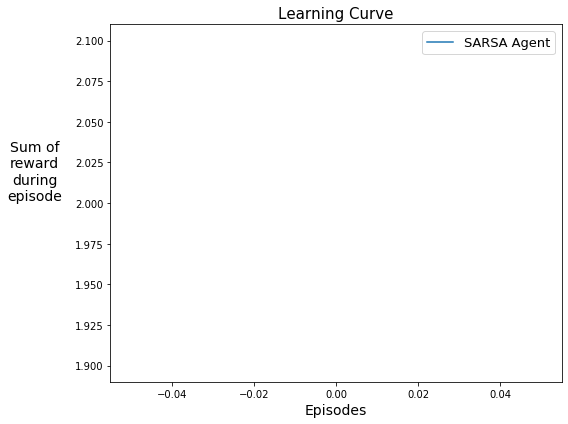

In [10]:
plot_result(["expected_sarsa_agent"])


In [11]:
data = np.load('results/sum_reward_expected_sarsa_agent.npy') 
print(data)

[[2.]]
